In [373]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [596]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sklearn.decomposition import PCA
import numpy as np
from mat6115.hidden import run_and_save_hidden, get_hidden
from mat6115.dataset import dataset_factory, TEXT, LABEL, SEED
from mat6115.model import RNN
from mat6115.train import custom_loss, acc
from mat6115.fixed_point import FixedPointFinder
from mat6115.analysis import load_model
from poutyne.framework import Model
import torch
from torch import nn
from pathlib import Path
import pickle
import json
plt.style.use('seaborn')
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
DPI = 300

In [386]:
train_iter, valid_iter, test_iter = dataset_factory("imdb", embedding="glove.6B.100d")

In [647]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
num_layers = 4
embedding_dim = 100

SAVE_PATH = Path(f'gru_{num_layers}layer_{embedding_dim}')
vanilla_model = load_model(SAVE_PATH)
trained_model = load_model(SAVE_PATH, restore=True)

vanilla_model.to(device)
trained_model.to(device)

/home/alexis/miniconda3/envs/mat6115/lib/python3.8/site-packages/torch/nn/modules/rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [648]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    length_tensor = torch.LongTensor(length)
    prediction = model.predict((tensor, length_tensor), batch_size=1)
    return 1 * LABEL.vocab.stoi['neg'] - 1 / (1 + np.exp(-prediction[0]))

In [649]:
def hidden_state_for_text(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    length_tensor = torch.LongTensor(length)
    return model.predict((tensor, length_tensor), batch_size=1)[1].squeeze(0)

In [650]:
predict_sentiment(trained_model, "This film is terrible")

array([0.0662961], dtype=float32)

In [651]:
predict_sentiment(vanilla_model, "This film is terrible")

array([0.50629914], dtype=float32)

### Load artifacts

In [652]:
pca_vanilla = []
pca_trained = []

pca_vanilla_2 = []
pca_trained_2 = []

vanilla_data, trained_data = [], []
fixed_point = []
converged_points = []
diff = []
starting_fixed_points = {}

with open(SAVE_PATH/"vanilla_ground_truth.npy", "rb") as f:
    vanilla_ground_truth = np.load(f)

with open(SAVE_PATH/"trained_ground_truth.npy", "rb") as f:
    trained_ground_truth = np.load(f)
        


for i in range(num_layers):
    with open(SAVE_PATH/f"{i+1}/pca_trained.pkl", "rb") as f:
        pca_trained.append(pickle.load(f))

    with open(SAVE_PATH/f"{i+1}/pca_vanilla.pkl", "rb") as f:
        pca_vanilla.append(pickle.load(f))

    with open(SAVE_PATH/f"{i+1}/pca_trained_n2.pkl", "rb") as f:
        pca_trained_2.append(pickle.load(f))

    with open(SAVE_PATH/f"{i+1}/pca_vanilla_n2.pkl", "rb") as f:
        pca_vanilla_2.append(pickle.load(f))
        
    with open(SAVE_PATH/f"{i+1}/transformed_vanilla_n2.npy", "rb") as f:
        vanilla_data.append(np.load(f))

    with open(SAVE_PATH/f"{i+1}/transformed_trained_n2.npy", "rb") as f:
        trained_data.append(np.load(f))

    with open(SAVE_PATH/f"{i+1}/unique_fixed_points.npy", "rb") as f:
        fixed_point.append(np.load(f))
        
    with open(SAVE_PATH/f"{i+1}/converged_points.npy", "rb") as f:
        converged_points.append(np.load(f))
        
    with open(SAVE_PATH/f"{i+1}/diff.npy", "rb") as f:
        diff.append(np.load(f))
    
    try:
        with open(SAVE_PATH/f"{i+1}/starting_fixed_points.npy", "rb") as f:
            starting_fixed_points[i] = np.load(f)
    except:
        pass

## Plotting

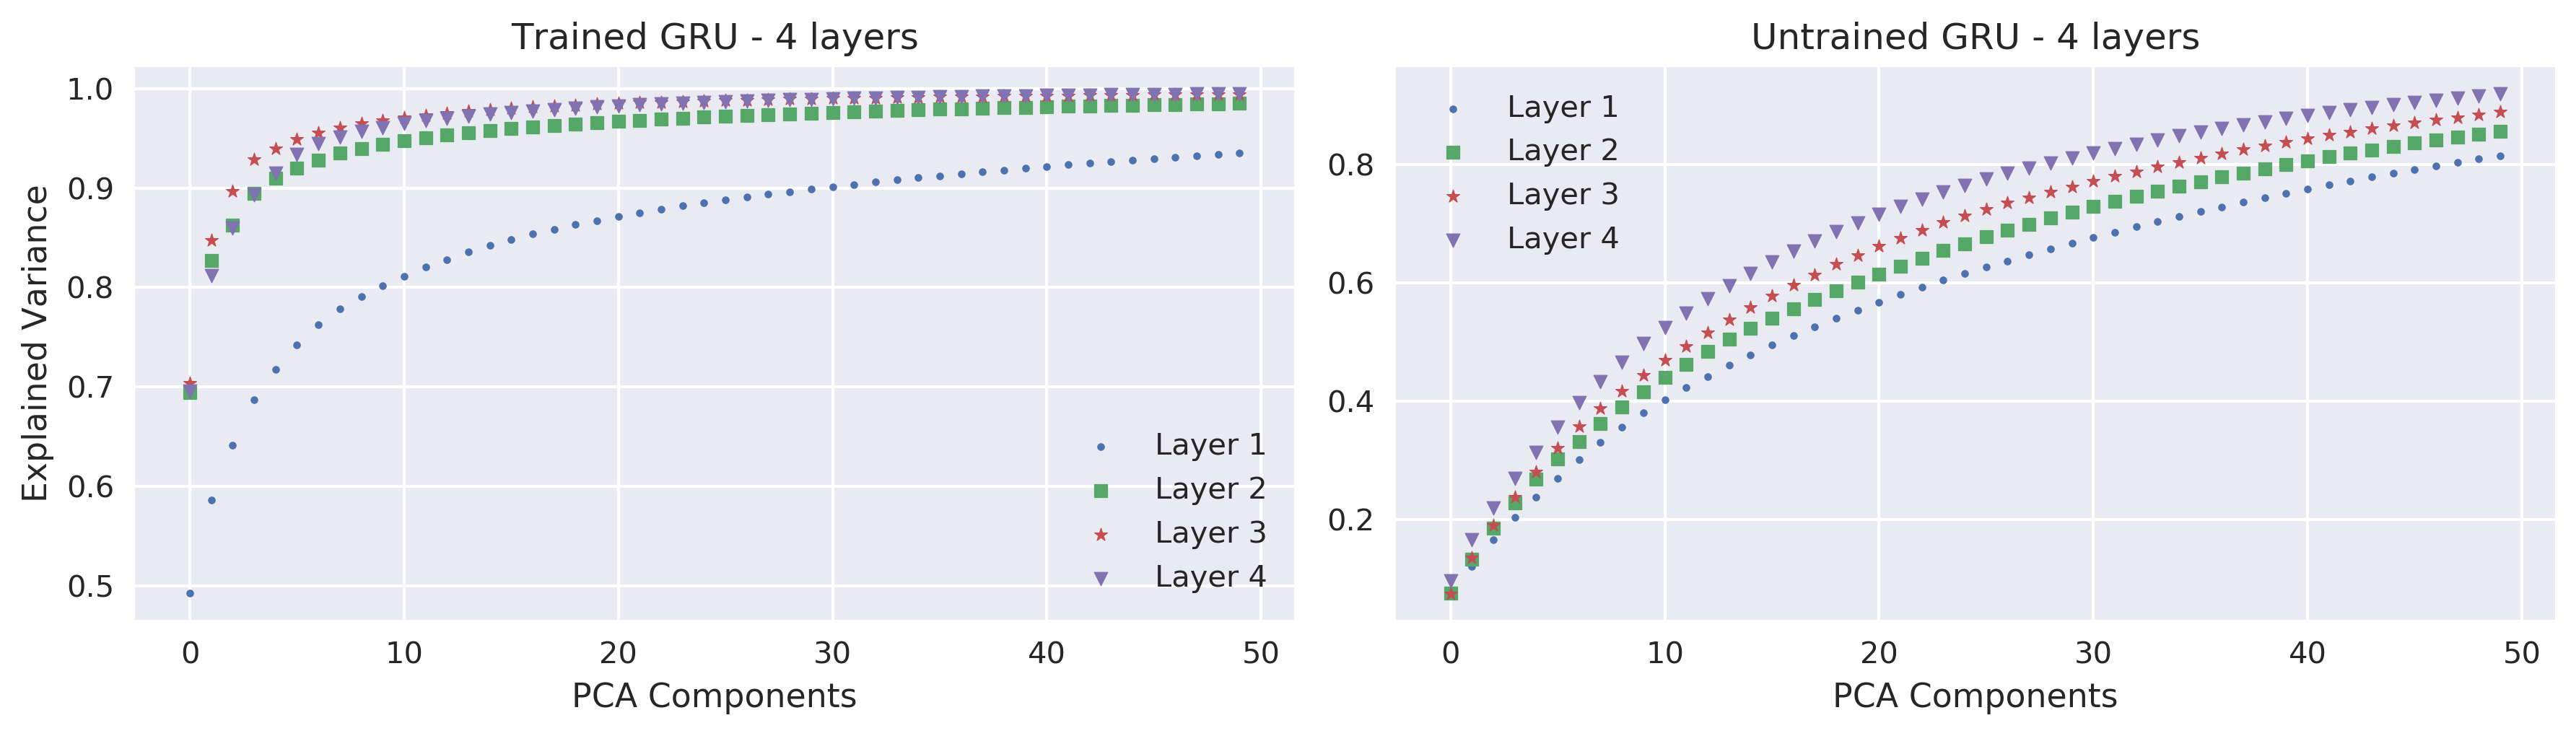

In [653]:
if num_layers == 1:
    fig, ax = plt.subplots(1, 1, figsize=(6, 3.5), dpi=DPI)
    ax.set_xlabel('PCA Components')
    ax.set_ylabel('Explained Variance')
    ax.set_title('1 layer GRU')
    
    trained_ax = ax
    untrained_ax = ax
else:
    fig, ax = plt.subplots(1, 2, figsize=(12, 3.5), dpi=DPI)
    trained_ax = ax[0]
    untrained_ax = ax[1]

    untrained_ax.set_xlabel('PCA Components')
    trained_ax.set_xlabel('PCA Components')

    untrained_ax.set_title(f'Untrained GRU - {num_layers} layers')
    trained_ax.set_title(f'Trained GRU - {num_layers} layers')

    trained_ax.set_ylabel('Explained Variance')

markers = [".", "s", "*", "v"]
for i in range(num_layers):
    trained_ax.scatter(
        np.arange(len(pca_trained[i].explained_variance_ratio_[:50])),
        pca_trained[i].explained_variance_ratio_.cumsum()[:50],
        s=20, marker=markers[i]
    )
    untrained_ax.scatter(
        np.arange(len(pca_vanilla[i].explained_variance_ratio_[:50])),
        pca_vanilla[i].explained_variance_ratio_.cumsum()[:50],
        s=20, marker=markers[i],
    )


if num_layers == 1:
    ax.legend(['Trained', 'Untrained'])
    
else:
    untrained_ax.legend([f'Layer {i}' for i in range(1, num_layers + 1)]) 
    trained_ax.legend([f'Layer {i}' for i in range(1, num_layers + 1)]) 

plt.tight_layout()
fig.savefig(f'images/gru_{num_layers}layer_{embedding_dim}_explained_variance.png')

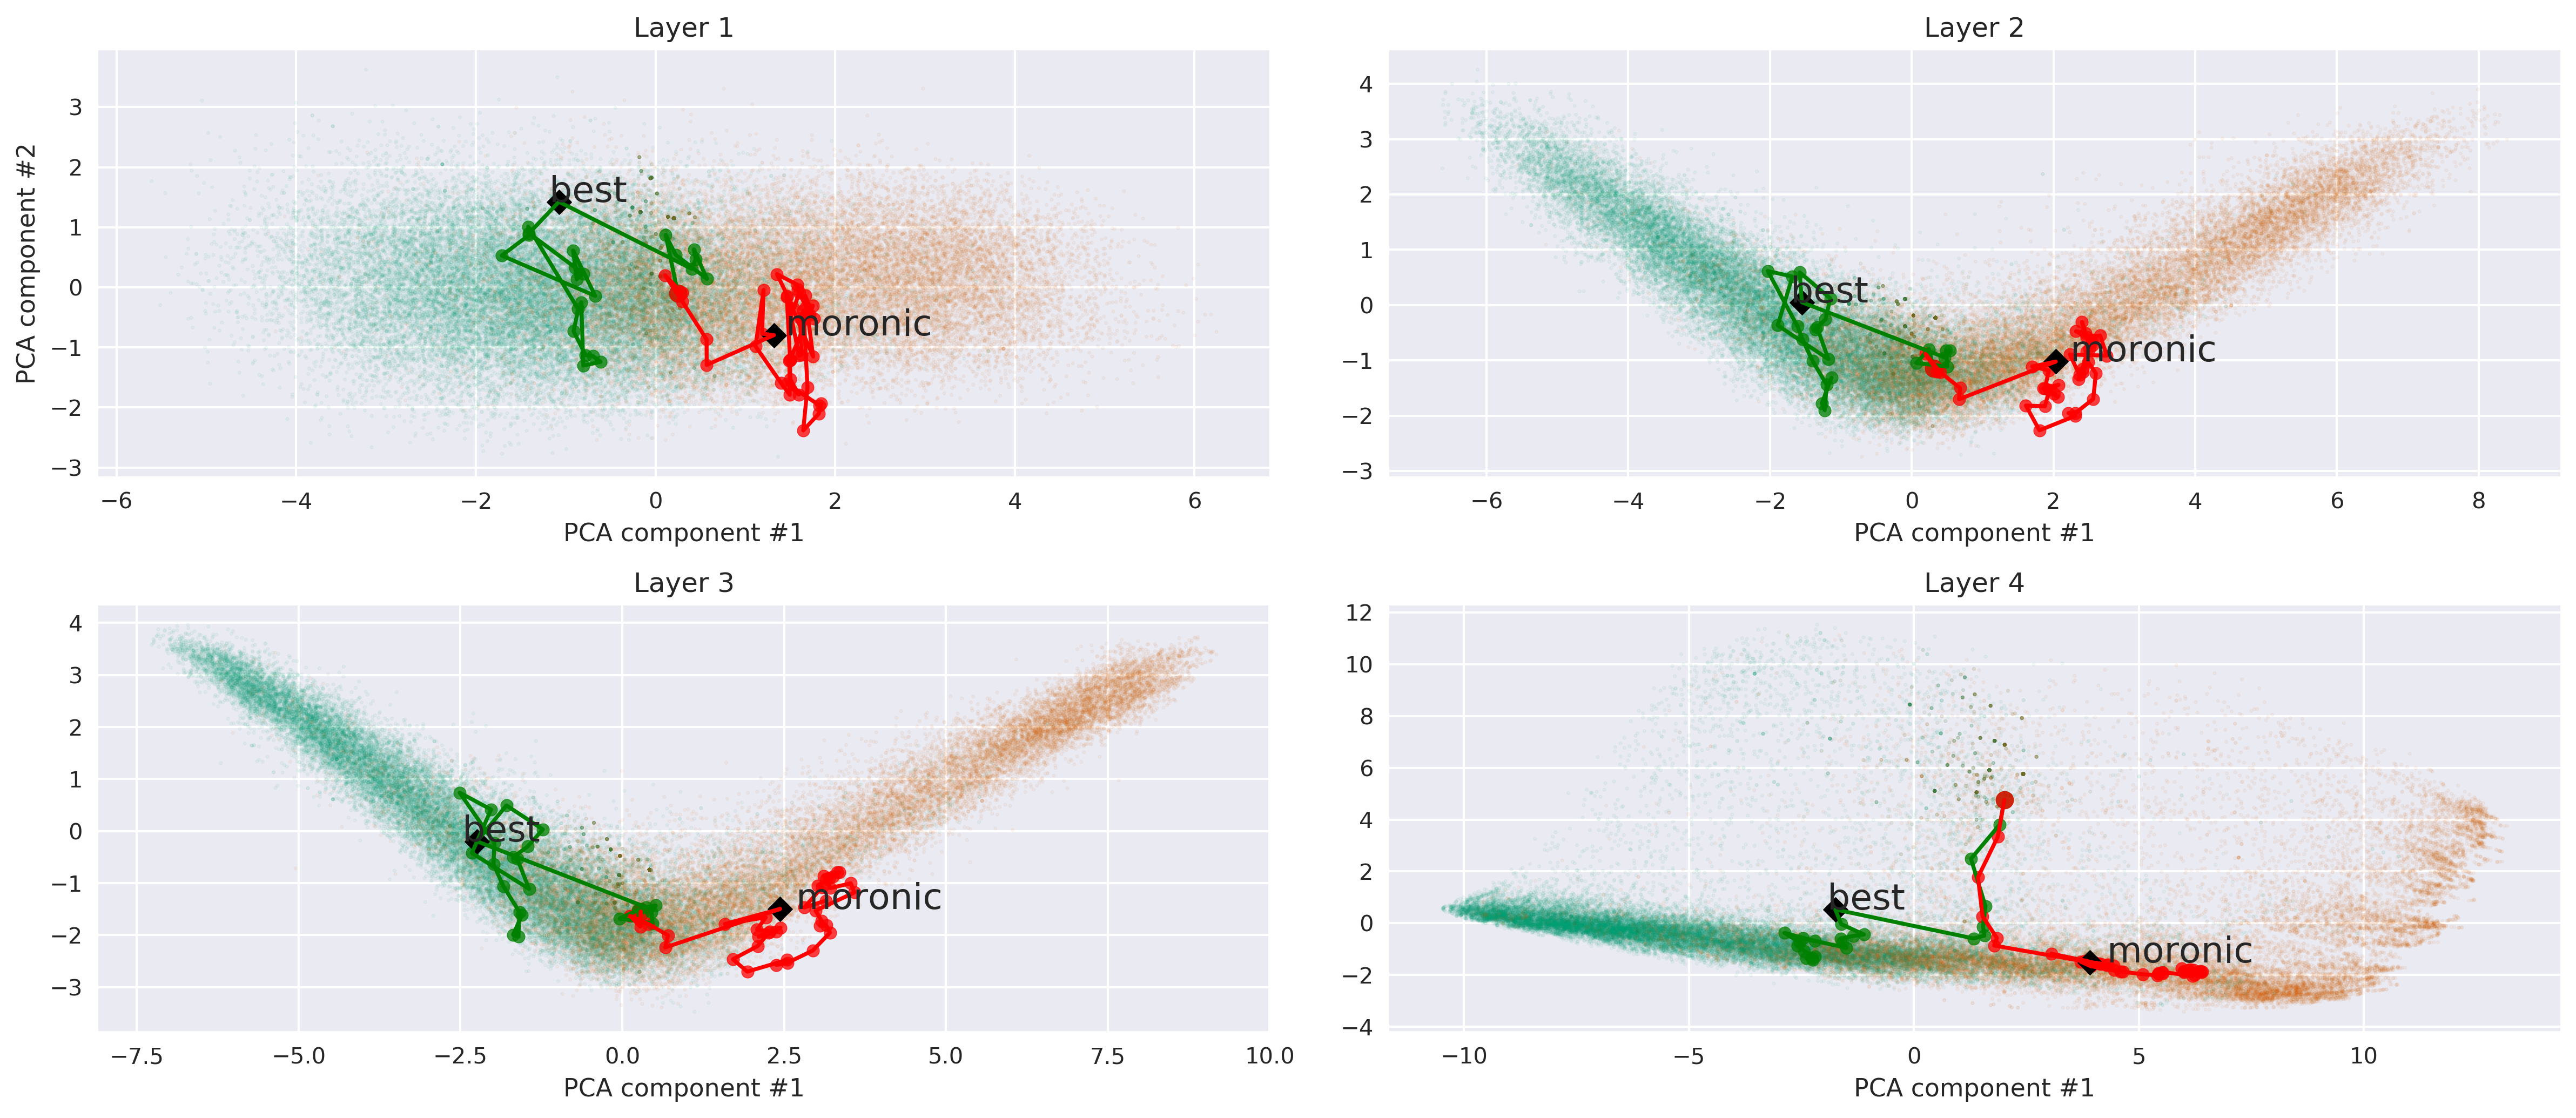

In [654]:
if num_layers == 4:
    fig, ax = plt.subplots(2, 2, figsize=(4*num_layers,7), dpi=DPI)
    ax = [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]
else:
    fig, ax = plt.subplots(1, num_layers, figsize=(6*num_layers,3.5), dpi=DPI)
    
GREEN = "#009E73"
RED = "#D55E00"

colors = np.array([GREEN] * len(trained_ground_truth))
colors[trained_ground_truth == LABEL.vocab.stoi['neg']] = RED
pos_idx = vanilla_ground_truth == LABEL.vocab.stoi['pos']
neg_idx = vanilla_ground_truth == LABEL.vocab.stoi['neg']

GREY = "#111111"
pos_text = (
    "It is by far one of the best comic book adaptations ever. "
    "I liked this one even more than X-men."
)
pos_text_hidden_states = hidden_state_for_text(trained_model, pos_text)

neg_text = (
    "First of all I hate those moronic rappers, who couldn't act if they had "
     "a gun pressed against their foreheads. All they do is curse and shoot "
     "each other and acting like cliché'e version of gangsters."
)
neg_text_hidden_states = hidden_state_for_text(trained_model, neg_text)

if num_layers == 1:
    ax = [ax]
for i in range(num_layers):
#     fp = pca_trained_2[i].transform(fixed_point[i])
    
    ax_ = ax[i]
    ax_.scatter(trained_data[i][:, 0], trained_data[i][:, 1], c=colors, alpha=0.05, s=2)
    ax_.set_title(f'Layer {i+1}')
    ax_.set_xlabel("PCA component #1")
    
    pos = pca_trained_2[i].transform(pos_text_hidden_states[i])
    neg = pca_trained_2[i].transform(neg_text_hidden_states[i])
    
    ax_.plot(pos[:, 0], pos[:, 1], c='g')
    ax_.plot(neg[:, 0], neg[:, 1], c='r')
    
    # Splot starting point
    ax_.scatter(pos[0, 0], pos[0, 1], c='g', s=60, alpha=0.75)
    ax_.scatter(neg[0, 0], neg[0, 1], c='r', s=60, alpha=0.75)

    ax_.scatter(pos[1:, 0], pos[1:, 1], c='g', s=30, alpha=0.75)
    ax_.scatter(neg[1:, 0], neg[1:, 1], c='r', s=30, alpha=0.75)
    
    ax_.text(pos[7,0]*1.1, pos[7,1], 'best', fontsize=16)
    ax_.text(neg[6,0]*1.1, neg[6,1], 'moronic', fontsize=16)
    
    ax_.scatter(pos[7,0], pos[7,1], marker="D", s=60, c='k')
    ax_.scatter(neg[6,0], neg[6,1], marker="D", s=60, c='k')
    
ax[0].set_ylabel("PCA component #2")
plt.tight_layout()
fig.savefig(f'images/gru_{num_layers}layer_{embedding_dim}_PCA.png')

## Starting fixed point (before convergeance)

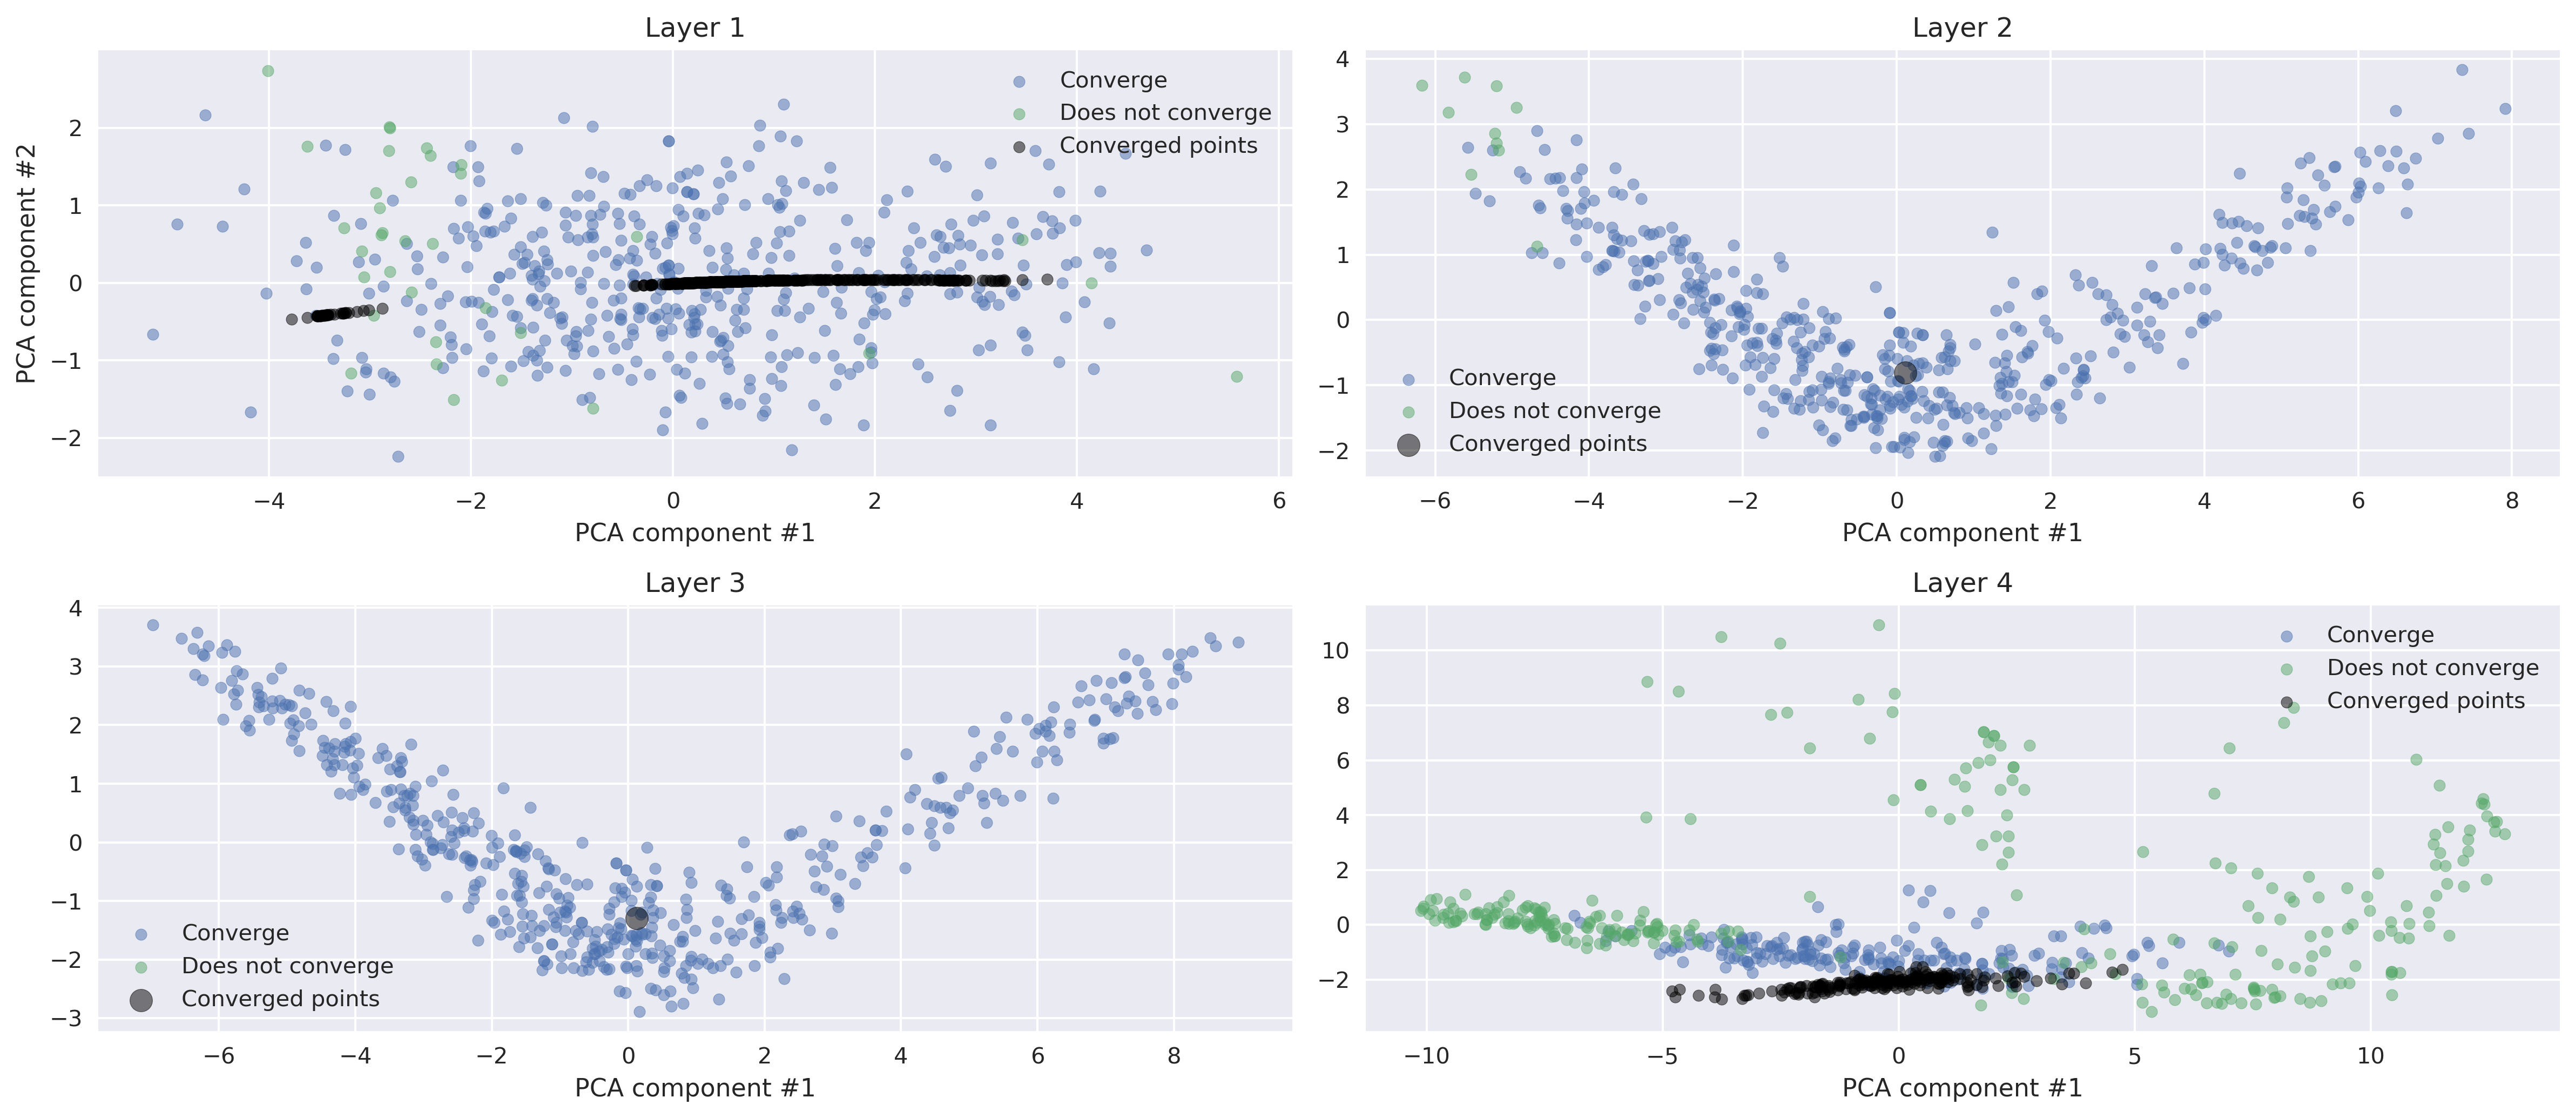

In [655]:
if num_layers == 4:
    fig, ax = plt.subplots(2, 2, figsize=(4*num_layers,7), dpi=DPI)
    ax = [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]
else:
    fig, ax = plt.subplots(1, num_layers, figsize=(6*num_layers,3.5), dpi=DPI)
    
colors = np.array([GREEN] * len(trained_ground_truth))
colors[trained_ground_truth == LABEL.vocab.stoi['neg']] = RED

GREY = "#111111"

if num_layers == 1:
    ax = [ax]
for i in range(num_layers):
    try:
        fp = pca_trained_2[i].transform(fixed_point[i])
   
        sfp = pca_trained_2[i].transform(starting_fixed_points[i].squeeze())
        d = diff[i]
        converged = d < 1e-6

        ax_ = ax[i]
#         ax_.scatter(trained_data[i][:, 0], trained_data[i][:, 1], c=colors, alpha=0.05, s=2)
        ax_.scatter(sfp[converged,0], sfp[converged,1],s=25, alpha=0.5)
        ax_.scatter(sfp[~converged,0], sfp[~converged,1],s=25, alpha=0.5)
        
        if len(fp) < 20:
            s=100
        else:
            s=25
        ax_.scatter(fp[:,0], fp[:,1], c='k', s=s, alpha=0.5)
        
        ax_.set_title(f'Layer {i+1}')
        ax_.set_xlabel("PCA component #1")
        ax_.legend(['Converge', 'Does not converge', 'Converged points'])
    except:
        continue

ax[0].set_ylabel("PCA component #2")
plt.tight_layout()
fig.savefig(f'images/gru_{num_layers}layer_{embedding_dim}_fixed_points.png')

## Eigenvalues 

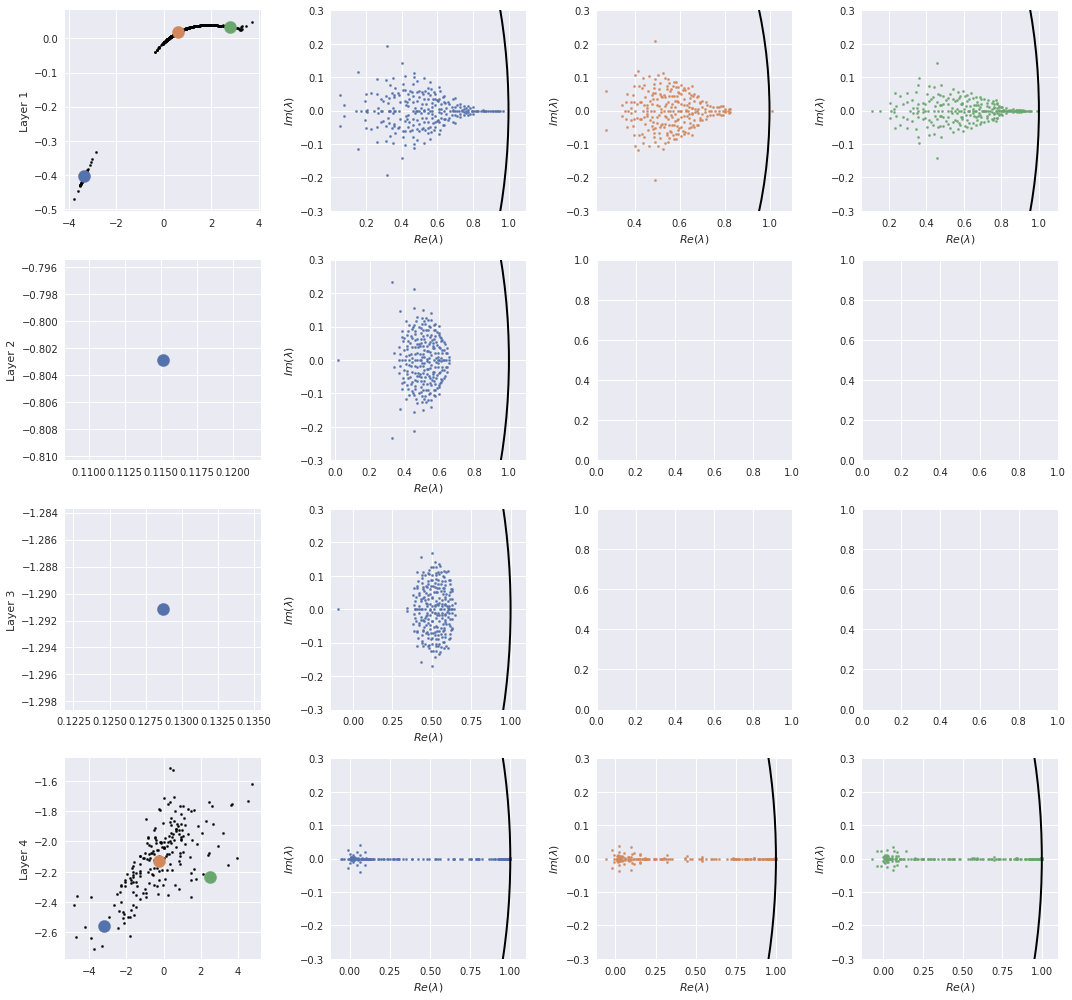

In [656]:
fig, ax = plt.subplots(num_layers, 4, figsize=(15, 3.5*num_layers))

if num_layers == 1:
    ax = [ax]
colors= ['#5472AB', "#D1885C", "#6AA66E"]

for i in range(num_layers):
    # pick 3 fixed point at random
    num_fp = len(fixed_point[i])
    if num_fp == 1:
        q = [50]
    elif num_fp == 2:
        q = [25,75]
    else:
        q = [5, 50, 95]
    idx = np.percentile(np.arange(num_fp), q, interpolation='nearest')
#     idx = sorted(np.random.choice(np.arange(num_fp), size=min(3, num_fp) , replace=False))
    
    fp = pca_trained_2[i].transform(fixed_point[i])
    sorted_idx = np.argsort(fp[:, 0])[idx]
    
    ax[i][0].scatter(fp[:,0], fp[:,1], c='k', s=5)
    ax[i][0].set_ylabel(f'Layer {i+1}')
    
    
    rnn = trained_model.network.rnn[i]
    input_dim = rnn.input_size
    constant_input = torch.zeros((1, 1, input_dim))   
    
    for j, point in enumerate(fixed_point[i][sorted_idx], 1):
        fp = pca_trained_2[i].transform(point[np.newaxis,:])
        ax[i][0].scatter(fp[:,0], fp[:,1], c=colors[j-1], s=150)

        point = torch.tensor(point).unsqueeze(0).unsqueeze(0)

        
        fixed_point_finder = FixedPointFinder(rnn_cell=rnn)
        jacobian_h, jacobian_i = fixed_point_finder.calc_jacobian(point, constant_input)
        
        eig_val, _ = np.linalg.eig(jacobian_h)
        ax[i][j].scatter(eig_val.real, eig_val.imag, c=colors[j-1], s=5)
        ax[i][j].set_ylabel("$Im(\lambda)$")
        ax[i][j].set_xlabel("$Re(\lambda)$")
        
        ax[i][j].add_artist(Circle((0,0), radius=1, fill=False, lw=2))
        ax[i][j].set_xlim(right=1.1)
        ax[i][j].set_ylim((-0.3, 0.3))
        

plt.tight_layout()
fig.savefig(f'images/gru_{num_layers}layer_{embedding_dim}_eig.png')